## Libraries importing

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 2.0

print("Libraries loaded. Ready for scientific computing.")

Libraries loaded. Ready for scientific computing.


## Full Data Loading

In [2]:
def load_and_clean_data(file_path):
    print("Loading Dataset...")
    df = pd.read_csv(file_path, parse_dates=['tstamp'])

    # 2. RENAME COLUMNS (To match our scientific code)
    # We rename 'tstamp' -> 'Date' and 'PotActiva' -> 'PotAtiva'
    df = df.rename(columns={'tstamp': 'Date', 'PotActiva': 'PotAtiva'})
    df = df.sort_values(by=['CPE', 'Date'])
    # 4. REMOVE DUPLICATES
    df = df.drop_duplicates(subset=['CPE', 'Date'], keep='first')

    # 5. SCIENTIFIC INTERPOLATION
    # Fill small gaps linearly to preserve data integrity
    df['PotAtiva'] = df.groupby('CPE')['PotAtiva'].transform(
        lambda x: x.interpolate(method='linear', limit=2)
    )

    # Drop rows that are still empty
    df = df.dropna(subset=['PotAtiva'])

    print(f"Data Loaded Successfully.")
    print(f"Unique Consumers: {df['CPE'].nunique()}")
    print(f"Total Observations: {len(df)}")
    print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")

    return df
filename = 'consumo15m_11_2025.csv'
df_raw = load_and_clean_data(filename)

Loading Dataset...
Data Loaded Successfully.
Unique Consumers: 91
Total Observations: 5938952
Date Range: 2022-12-31 00:15:00 to 2025-05-01 00:00:00


## Feature Engineering

In [3]:
def generate_research_features(df):
    print("Processing Time-Series Features...")

    # 1. RESAMPLE TO HOURLY
    df = df.set_index('Date')
    df_hourly = df.groupby('CPE')['PotAtiva'].resample('1H').mean().reset_index()

    # 2. FILL GAPS
    df_hourly['PotAtiva'] = df_hourly.groupby('CPE')['PotAtiva'].transform(
        lambda x: x.interpolate(method='linear', limit=24)
    )

    # 3. GENERATE TIME FEATURES
    df_hourly['Hour'] = df_hourly['Date'].dt.hour
    df_hourly['DayOfWeek'] = df_hourly['Date'].dt.dayofweek

    # Cyclical Features (REQUIRED by Cell 6)
    df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['Hour'] / 24)
    df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['Hour'] / 24)
    df_hourly['day_sin'] = np.sin(2 * np.pi * df_hourly['DayOfWeek'] / 7)
    df_hourly['day_cos'] = np.cos(2 * np.pi * df_hourly['DayOfWeek'] / 7)

    # 4. GENERATE LAG FEATURES (The Memory)
    grouped = df_hourly.groupby('CPE')['PotAtiva']

    df_hourly['lag_24h'] = grouped.shift(24)      # Yesterday
    df_hourly['lag_168h'] = grouped.shift(168)    # Last Week

    # 5. GENERATE ROLLING STATISTICS
    df_hourly['rolling_mean_7d'] = grouped.shift(168).rolling(window=24).mean()

    # Rolling Volatility (Standard Deviation)
    df_hourly['rolling_std_24h'] = grouped.shift(1).rolling(window=24).std()

    # 6. FINAL CLEANUP
    df_clean = df_hourly.dropna(subset=['PotAtiva', 'lag_168h', 'rolling_mean_7d'])

    print(f"Features Generated. Final shape: {df_clean.shape}")
    return df_clean

df_features = generate_research_features(df_raw)

Processing Time-Series Features...
Features Generated. Final shape: (1459486, 13)


## Clustering Methodology

Optimizing Clusters...


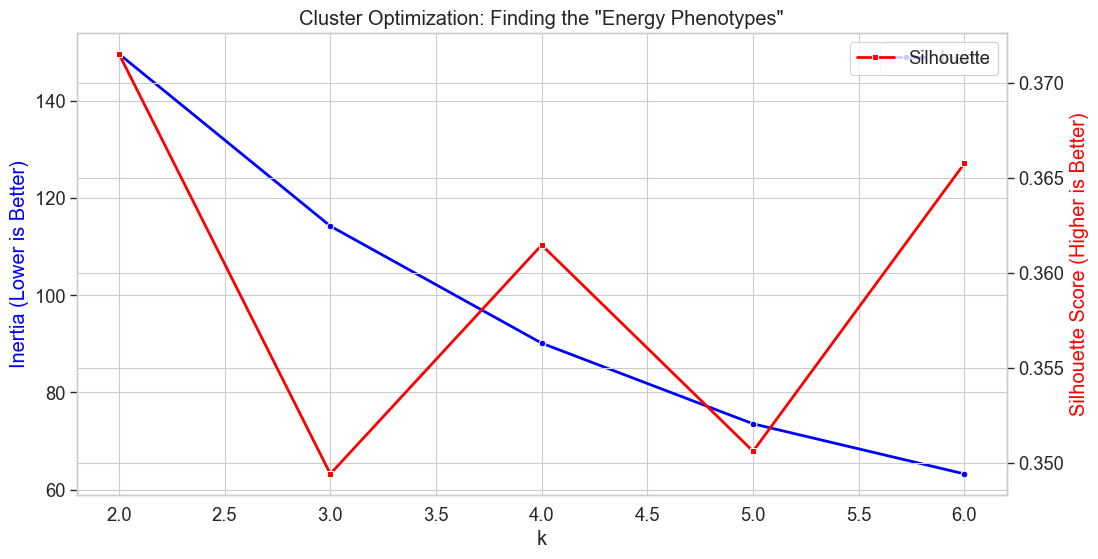

Mathematically Optimal Clusters (K): 2


In [4]:
def optimize_clusters(df):
    print("Optimizing Clusters...")

    # 1. CREATE LOAD PROFILES
    # Pivot: Rows=CPEs, Cols=Hours (0-23). We average usage per hour.
    # This creates a "Daily Signature" for each user.
    daily_profiles = df.groupby(['CPE', df['Date'].dt.hour])['PotAtiva'].mean().unstack()

    # Normalize (So high users don't dominate low users just by volume)
    scaler = MinMaxScaler()
    daily_profiles_norm = pd.DataFrame(
        scaler.fit_transform(daily_profiles.T).T,
        index=daily_profiles.index,
        columns=daily_profiles.columns
    )

    # 2. TEST K (2 to 6)
    results = []
    K_range = range(2, 7)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(daily_profiles_norm)
        score = silhouette_score(daily_profiles_norm, labels)
        inertia = kmeans.inertia_
        results.append({'k': k, 'silhouette': score, 'inertia': inertia})

    results_df = pd.DataFrame(results)

    fig, ax1 = plt.subplots()

    # Inertia (Elbow)
    sns.lineplot(data=results_df, x='k', y='inertia', marker='o', ax=ax1, color='blue', label='Inertia')
    ax1.set_ylabel('Inertia (Lower is Better)', color='blue')

    # Silhouette (Quality)
    ax2 = ax1.twinx()
    sns.lineplot(data=results_df, x='k', y='silhouette', marker='s', ax=ax2, color='red', label='Silhouette')
    ax2.set_ylabel('Silhouette Score (Higher is Better)', color='red')

    plt.title('Cluster Optimization: Finding the "Energy Phenotypes"')
    plt.show()

    best_k = results_df.loc[results_df['silhouette'].idxmax()]['k']
    print(f"Mathematically Optimal Clusters (K): {int(best_k)}")

    return int(best_k), daily_profiles_norm

best_k, profiles_norm = optimize_clusters(df_features)

In [5]:
def apply_clusters(df, k=2):
    print(f"Applying K-Means with K={k}...")

    # 1. Prepare Data (Same normalization as Cell 4)
    daily_profiles = df.groupby(['CPE', df['Date'].dt.hour])['PotAtiva'].mean().unstack()
    scaler = MinMaxScaler()
    daily_profiles_norm = pd.DataFrame(
        scaler.fit_transform(daily_profiles.T).T,
        index=daily_profiles.index,
        columns=daily_profiles.columns
    )

    # 2. Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(daily_profiles_norm)

    # 3. Save Labels to the Main DataFrame
    # Map the cluster label back to the original dataframe based on CPE
    cluster_map = pd.Series(cluster_labels, index=daily_profiles.index)
    df['Cluster'] = df['CPE'].map(cluster_map)

    print("Cluster counts:")
    print(df.groupby('CPE')['Cluster'].first().value_counts())

    return df

df_final = apply_clusters(df_features, k=2)

Applying K-Means with K=2...
Cluster counts:
Cluster
0    63
1    28
Name: count, dtype: int64


## Finding Energy Behaviour

Generating Cluster Profile Visuals...


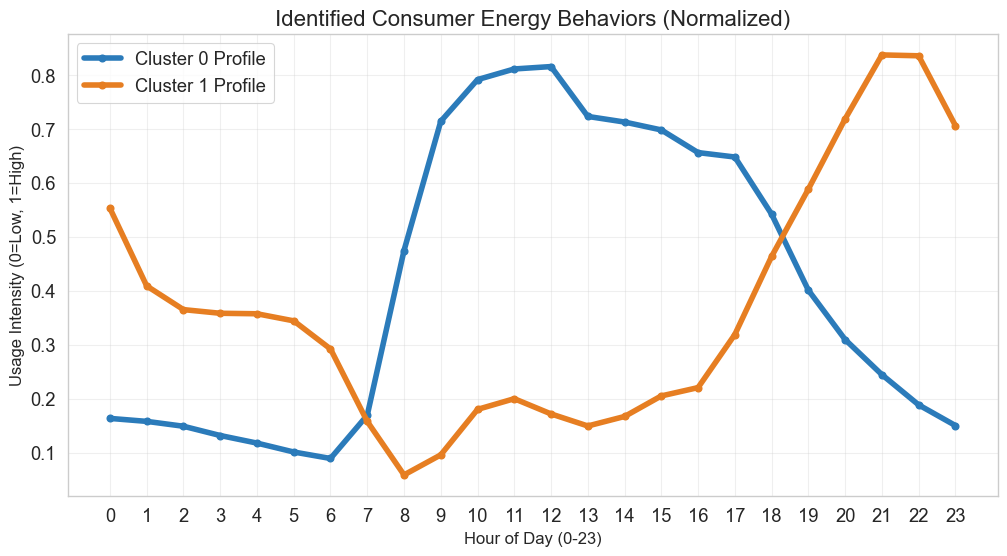

In [12]:
def plot_cluster_profiles(df):
    print("Generating Cluster Profile Visuals...")

    # 1. PREPARE DATA
    # Pivot to get the "Daily Shape" for every user
    daily_profiles = df.groupby(['CPE', df['Date'].dt.hour])['PotAtiva'].mean().unstack()

    # Normalize (0-1)
    scaler = MinMaxScaler()
    daily_profiles_norm = pd.DataFrame(
        scaler.fit_transform(daily_profiles.T).T,
        index=daily_profiles.index,
        columns=daily_profiles.columns
    )

    # 2. CALCULATE CENTROIDS (THE FIX IS HERE)
    # We create a clean map of CPE -> Cluster by dropping duplicates first
    cluster_map = df[['CPE', 'Cluster']].drop_duplicates().set_index('CPE')['Cluster']

    # Now we group the profiles using this clean map
    centroids = daily_profiles_norm.groupby(cluster_map).mean()

    # 3. PLOT
    plt.figure(figsize=(12, 6))
    colors = ['#2b7bba', '#e67e22', '#27ae60']

    for i, cluster_id in enumerate(centroids.index):
        plt.plot(
            centroids.columns,
            centroids.loc[cluster_id],
            linewidth=4,
            marker='o',
            label=f'Cluster {int(cluster_id)} Profile',
            color=colors[i % len(colors)]
        )

    plt.title('Identified Consumer Energy Behaviors (Normalized)', fontsize=16)
    plt.xlabel('Hour of Day (0-23)', fontsize=12)
    plt.ylabel('Usage Intensity (0=Low, 1=High)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    plt.show()

plot_cluster_profiles(df_final)

## ploting clusters

Generating Publication-Quality PCA Plot...


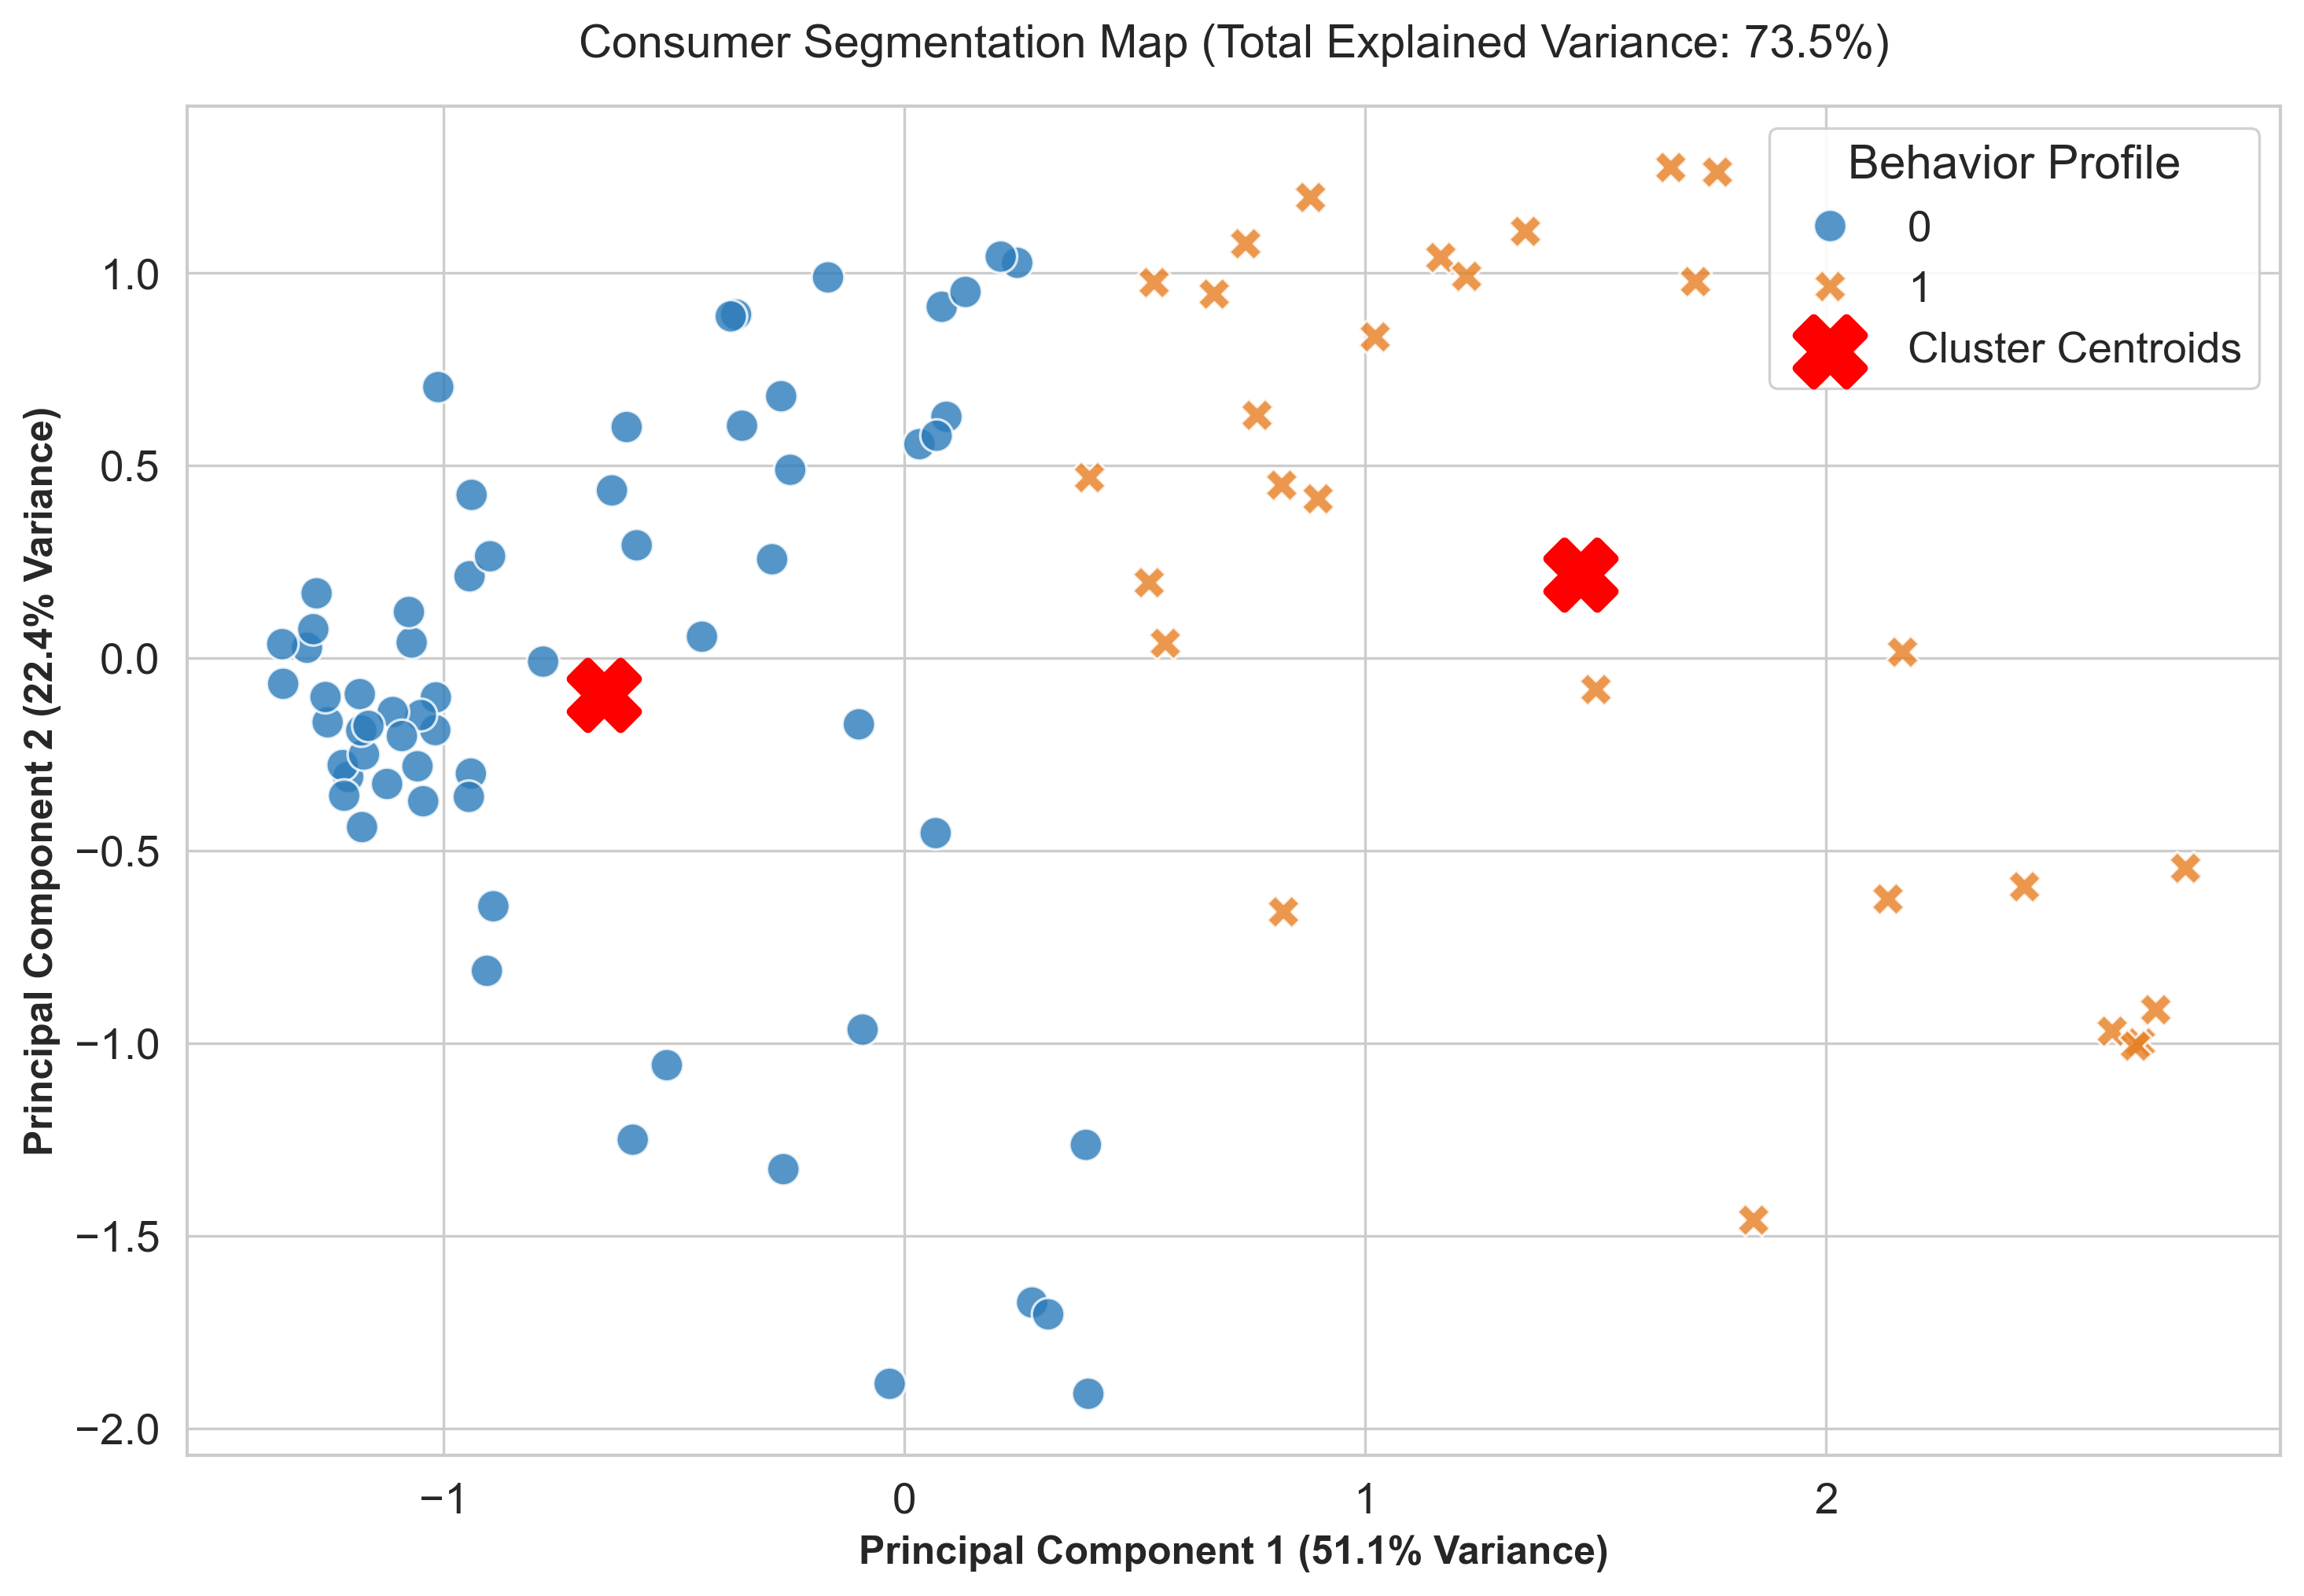

In [18]:
from sklearn.decomposition import PCA
def plot_best_pca(df):
    print("Generating Publication-Quality PCA Plot...")

    # 1. PREPARE DATA
    # Ensure we have the hour column
    if 'Hour' not in df.columns:
        df['Hour'] = df['Date'].dt.hour

    # Pivot: Rows=Consumers, Cols=Hours (The "Shape" of usage)
    daily_profiles = df.groupby(['CPE', 'Hour'])['PotAtiva'].mean().unstack()

    # Normalize (Critical for PCA)
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(daily_profiles.T).T,
                     index=daily_profiles.index,
                     columns=daily_profiles.columns)

    # Get Cluster Labels (Ensure they exist)
    if 'Cluster' in df.columns:
        # Create a map {CPE: ClusterLabel} to ensure alignment
        cluster_map = df.groupby('CPE')['Cluster'].first()
        labels = X.index.map(cluster_map)
    else:
        print("Error: Please run the clustering cell first to assign labels.")
        return

    # 2. CALCULATE PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Calculate Variance Explained (Good for paper caption)
    var_exp = pca.explained_variance_ratio_
    total_var = sum(var_exp) * 100

    # 3. CALCULATE TRUE CENTROIDS IN PCA SPACE
    # (We find the center in 24D, then project it to 2D)
    # This is more accurate than just averaging the dots
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans.fit(X) # Re-fit on aligned data to get centers
    centroids_pca = pca.transform(kmeans.cluster_centers_)

    # 4. PLOT CONFIGURATION
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 7), dpi=300) # High DPI for printing

    # Plot the dots (Consumers)
    scatter = sns.scatterplot(
        x=X_pca[:, 0],
        y=X_pca[:, 1],
        hue=labels,
        palette=['#2b7bba', '#e67e22'], # Professional Blue & Orange
        style=labels, # Different shapes for colorblind accessibility
        s=100,
        alpha=0.8,
        edgecolor='w'
    )

    # Plot the Centroids (Red X)
    plt.scatter(
        centroids_pca[:, 0], centroids_pca[:, 1],
        marker='X', s=400, linewidths=3,
        color='red', label='Cluster Centroids', zorder=10
    )

    # 5. LABELS & LEGEND
    plt.xlabel(f'Principal Component 1 ({var_exp[0]:.1%} Variance)', fontsize=12, fontweight='bold')
    plt.ylabel(f'Principal Component 2 ({var_exp[1]:.1%} Variance)', fontsize=12, fontweight='bold')
    plt.title(f'Consumer Segmentation Map (Total Explained Variance: {total_var:.1f}%)', fontsize=14, pad=15)

    # Custom Legend
    handles, _ = scatter.get_legend_handles_labels()
    # Add the centroid marker to legend manually if needed, or rely on clear visual
    plt.legend(title='Behavior Profile', loc='upper right', frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.show()


plot_best_pca(df_final)

## deploying Hybrid model

Initializing Scientific Forecasting Experiment...
Training on 762151 samples. Testing on 128249 samples.
Training Global Model...
Training Cluster-Specific Models...

=== FINAL RESULTS (Experiment 1) ===
               Model       MAE
2  Hybrid (Proposed)  1.265756
1     Global XGBoost  1.292034
0     Naive Baseline  1.724130


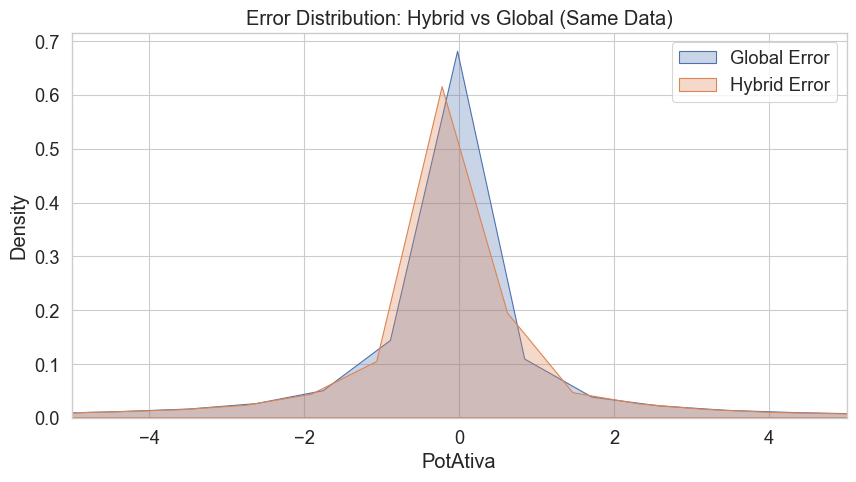

In [14]:
import xgboost as xgb

def run_experiment(df):
    print("Initializing Scientific Forecasting Experiment...")

    # 1. STANDARDIZE DATA (Match Cell 8's logic)
    # We filter to keep only the last 365 days + 60 days for testing
    # This ensures Experiment 1 and 2 use the EXACT same data
    cutoff_date = df['Date'].max() - pd.Timedelta(days=365 + 60)
    df_recent = df[df['Date'] > cutoff_date].copy()

    # 2. TRAIN/TEST SPLIT
    split_date = df_recent['Date'].max() - pd.Timedelta(days=60)
    train = df_recent[df_recent['Date'] < split_date]
    test = df_recent[df_recent['Date'] >= split_date]

    print(f"Training on {len(train)} samples. Testing on {len(test)} samples.")

    # FEATURES
    features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                'lag_24h', 'lag_168h', 'rolling_mean_7d', 'rolling_std_24h']
    target = 'PotAtiva'

    results = []

    # --- MODEL A: NAIVE BASELINE ---
    baseline_mae = mean_absolute_error(test[target], test['lag_168h'])
    results.append({'Model': 'Naive Baseline', 'MAE': baseline_mae})

    # --- MODEL B: GLOBAL XGBOOST ---
    print("Training Global Model...")
    global_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
    global_model.fit(train[features], train[target])

    global_pred = global_model.predict(test[features])
    global_mae = mean_absolute_error(test[target], global_pred)
    results.append({'Model': 'Global XGBoost', 'MAE': global_mae})

    # --- MODEL C: HYBRID CLUSTER MODEL ---
    print("Training Cluster-Specific Models...")
    test_clustered = test.copy()
    test_clustered['Hybrid_Pred'] = 0.0

    for k in sorted(df['Cluster'].unique()):
        # Filter data for this specific cluster
        k_train = train[train['Cluster'] == k]
        k_test = test_clustered[test_clustered['Cluster'] == k]

        if len(k_test) == 0: continue

        k_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
        k_model.fit(k_train[features], k_train[target])

        test_clustered.loc[k_test.index, 'Hybrid_Pred'] = k_model.predict(k_test[features])

    hybrid_mae = mean_absolute_error(test_clustered[target], test_clustered['Hybrid_Pred'])
    results.append({'Model': 'Hybrid (Proposed)', 'MAE': hybrid_mae})

    # 3. FINAL REPORT
    results_df = pd.DataFrame(results).sort_values(by='MAE')

    print("\n=== FINAL RESULTS (Experiment 1) ===")
    print(results_df)

    # VISUALIZATION
    plt.figure(figsize=(10, 5))
    sns.kdeplot(test[target] - global_pred, label='Global Error', fill=True, alpha=0.3)
    sns.kdeplot(test_clustered[target] - test_clustered['Hybrid_Pred'], label='Hybrid Error', fill=True, alpha=0.3)
    plt.xlim(-5, 5)
    plt.title("Error Distribution: Hybrid vs Global (Same Data)")
    plt.legend()
    plt.show()

    return results_df
final_results = run_experiment(df_final)

The Comparative Forecasting Loop

Starting Optimized High-Accuracy Race...
Training on 642599 recent samples.
Training LightGBM...
Training XGBoost...
Training HistGradient...
Training Voting Ensemble...

=== FINAL ACCURACY REPORT ===
                 Model        R2       MAE
3  Ensemble (Combined)  0.909052  1.278460
0             LightGBM  0.907375  1.296556
1              XGBoost  0.901552  1.306323
2         HistGradient  0.904655  1.324477


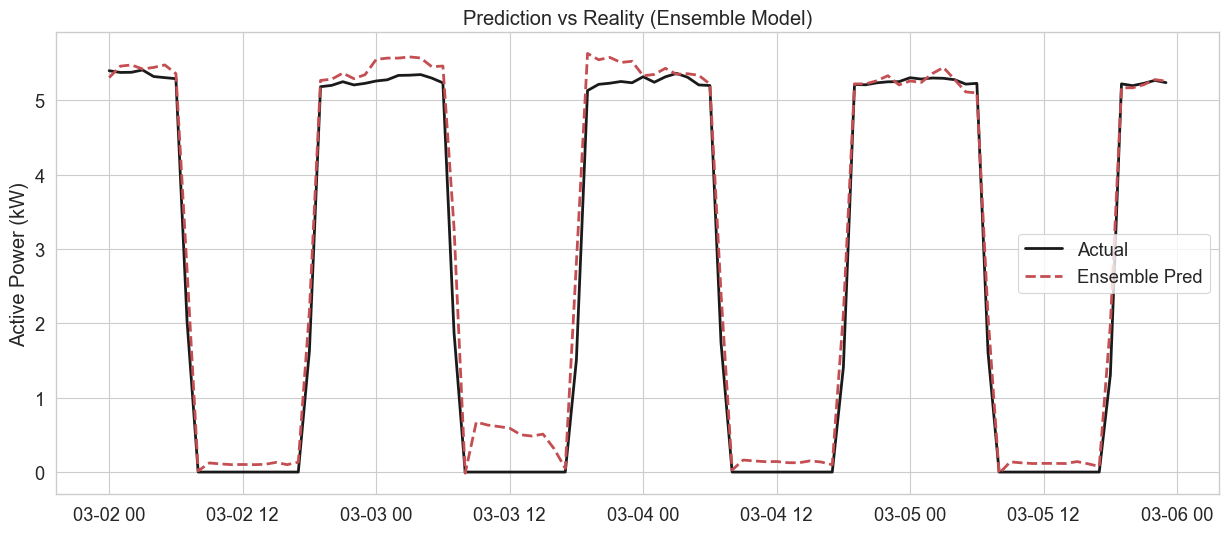

In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

def run_high_accuracy_experiment(df):
    print("Starting Optimized High-Accuracy Race...")

    # 1. OPTIMIZED SPLIT (Last 12 Months to save RAM)
    cutoff_date = df['Date'].max() - pd.Timedelta(days=365)
    df_recent = df[df['Date'] > cutoff_date].copy()

    split_date = df_recent['Date'].max() - pd.Timedelta(days=60)
    train = df_recent[df_recent['Date'] < split_date]
    test = df_recent[df_recent['Date'] >= split_date]

    print(f"Training on {len(train)} recent samples.")

    features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                'lag_24h', 'lag_168h', 'rolling_mean_7d', 'rolling_std_24h']
    target = 'PotAtiva'

    results = []
    trained_estimators = []

    # 2. DEFINE MODELS
    models = {
        'LightGBM': lgb.LGBMRegressor(n_estimators=300, random_state=42, verbose=-1, n_jobs=1),
        'XGBoost': xgb.XGBRegressor(n_estimators=300, max_depth=6, random_state=42, n_jobs=1),
        'HistGradient': HistGradientBoostingRegressor(max_iter=300, random_state=42)
    }

    # 3. TRAIN LOOP
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(train[features], train[target])
        pred = model.predict(test[features])

        r2 = r2_score(test[target], pred)
        mae = mean_absolute_error(test[target], pred)
        results.append({'Model': name, 'R2': r2, 'MAE': mae})
        trained_estimators.append((name, model))

    # 4. ENSEMBLE (Combine them all)
    print("Training Voting Ensemble...")
    ensemble = VotingRegressor(estimators=trained_estimators, n_jobs=1)
    ensemble.fit(train[features], train[target])
    ens_pred = ensemble.predict(test[features])

    results.append({'Model': 'Ensemble (Combined)',
                    'R2': r2_score(test[target], ens_pred),
                    'MAE': mean_absolute_error(test[target], ens_pred)})

    # 5. RESULTS TABLE
    results_df = pd.DataFrame(results).sort_values(by='MAE')
    print("\n=== FINAL ACCURACY REPORT ===")
    print(results_df)

    # 6. PLOT (First 4 Days of Test)
    plt.figure(figsize=(15, 6))
    sample = test.iloc[0:96]

    plt.plot(sample['Date'], sample[target], 'k-', label='Actual', linewidth=2)
    plt.plot(sample['Date'], ens_pred[0:96], 'r--', label='Ensemble Pred', linewidth=2)

    plt.title('Prediction vs Reality (Ensemble Model)')
    plt.ylabel('Active Power (kW)')
    plt.legend()
    plt.show()

run_high_accuracy_experiment(df_final)

## STATISTICAL ROBUSTNESS TEST

Running Stress Test: 30 Iterations to confirm statistical significance...
  > Trial 5/30 complete...
  > Trial 10/30 complete...
  > Trial 15/30 complete...
  > Trial 20/30 complete...
  > Trial 25/30 complete...
  > Trial 30/30 complete...

=== STRESS TEST RESULTS (30 FOLDS) ===
Global Model Avg MAE: 1.2507 (+/- 0.2722)
Hybrid Model Avg MAE: 1.2263 (+/- 0.2681)
Hybrid Win Rate:      93.3% of trials


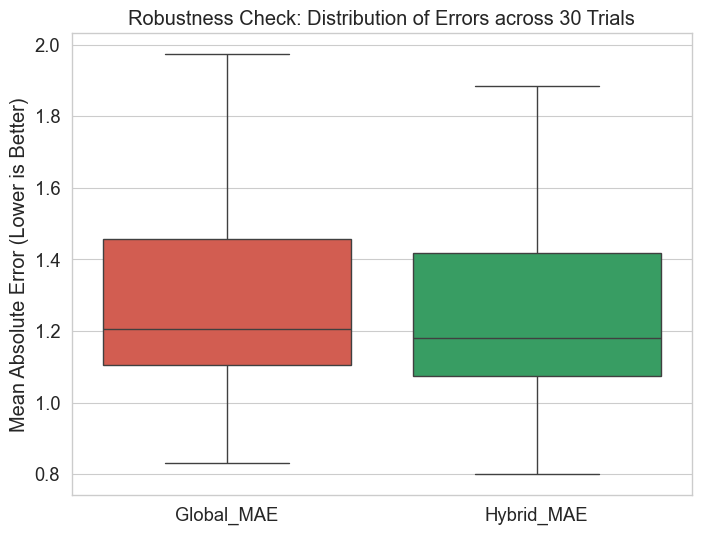

In [15]:
from sklearn.model_selection import TimeSeriesSplit
def run_stress_test(df, n_trials=30):
    print(f"Running Stress Test: {n_trials} Iterations to confirm statistical significance...")

    cutoff_date = df['Date'].max() - pd.Timedelta(days=425)
    df_recent = df[df['Date'] > cutoff_date].copy()

    features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                'lag_24h', 'lag_168h', 'rolling_mean_7d', 'rolling_std_24h']
    target = 'PotAtiva'

    # Store results for every single run
    trial_results = []

    tscv = TimeSeriesSplit(n_splits=n_trials, test_size=24*7) # Test on 1 week chunks

    # We need to sort by date for TimeSeriesSplit to work
    df_recent = df_recent.sort_values('Date')

    # We group by date index to split simpler
    unique_dates = df_recent['Date'].unique()

    iteration = 1
    for train_idx, test_idx in tscv.split(unique_dates):
        # Map date indices back to dataframe rows
        # (This logic handles the multiple rows per timestamp issue)
        train_dates = unique_dates[train_idx]
        test_dates = unique_dates[test_idx]

        train = df_recent[df_recent['Date'].isin(train_dates)]
        test = df_recent[df_recent['Date'].isin(test_dates)]

        # SKIP if test set is too small (sanity check)
        if len(test) < 24: continue

        # --- A. GLOBAL MODEL ---
        # We vary random_state slightly to test stability
        seed = 42 + iteration
        global_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=seed)
        global_model.fit(train[features], train[target])
        global_pred = global_model.predict(test[features])
        global_mae = mean_absolute_error(test[target], global_pred)

        # --- B. HYBRID MODEL ---
        test_clustered = test.copy()
        test_clustered['Hybrid_Pred'] = 0.0

        for k in df['Cluster'].unique():
            k_train = train[train['Cluster'] == k]
            k_test = test_clustered[test_clustered['Cluster'] == k]

            if len(k_test) == 0: continue

            k_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=seed)
            k_model.fit(k_train[features], k_train[target])
            test_clustered.loc[k_test.index, 'Hybrid_Pred'] = k_model.predict(k_test[features])

        hybrid_mae = mean_absolute_error(test_clustered[target], test_clustered['Hybrid_Pred'])

        # Store Diff
        improvement = global_mae - hybrid_mae
        trial_results.append({
            'Iteration': iteration,
            'Global_MAE': global_mae,
            'Hybrid_MAE': hybrid_mae,
            'Improvement': improvement
        })

        if iteration % 5 == 0:
            print(f"  > Trial {iteration}/{n_trials} complete...")
        iteration += 1

    # 3. FINAL STATISTICS
    stats_df = pd.DataFrame(trial_results)

    mean_global = stats_df['Global_MAE'].mean()
    mean_hybrid = stats_df['Hybrid_MAE'].mean()
    win_rate = (stats_df['Hybrid_MAE'] < stats_df['Global_MAE']).mean() * 100

    print("\n=== STRESS TEST RESULTS (30 FOLDS) ===")
    print(f"Global Model Avg MAE: {mean_global:.4f} (+/- {stats_df['Global_MAE'].std():.4f})")
    print(f"Hybrid Model Avg MAE: {mean_hybrid:.4f} (+/- {stats_df['Hybrid_MAE'].std():.4f})")
    print(f"Hybrid Win Rate:      {win_rate:.1f}% of trials")

    # Boxplot to visualize the spread
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=stats_df[['Global_MAE', 'Hybrid_MAE']], palette=['#e74c3c', '#27ae60'])
    plt.title(f'Robustness Check: Distribution of Errors across {n_trials} Trials')
    plt.ylabel('Mean Absolute Error (Lower is Better)')
    plt.show()

    return stats_df

# === EXECUTION ===
stress_results = run_stress_test(df_final, n_trials=30)

## MODEL COMPARING PLOT

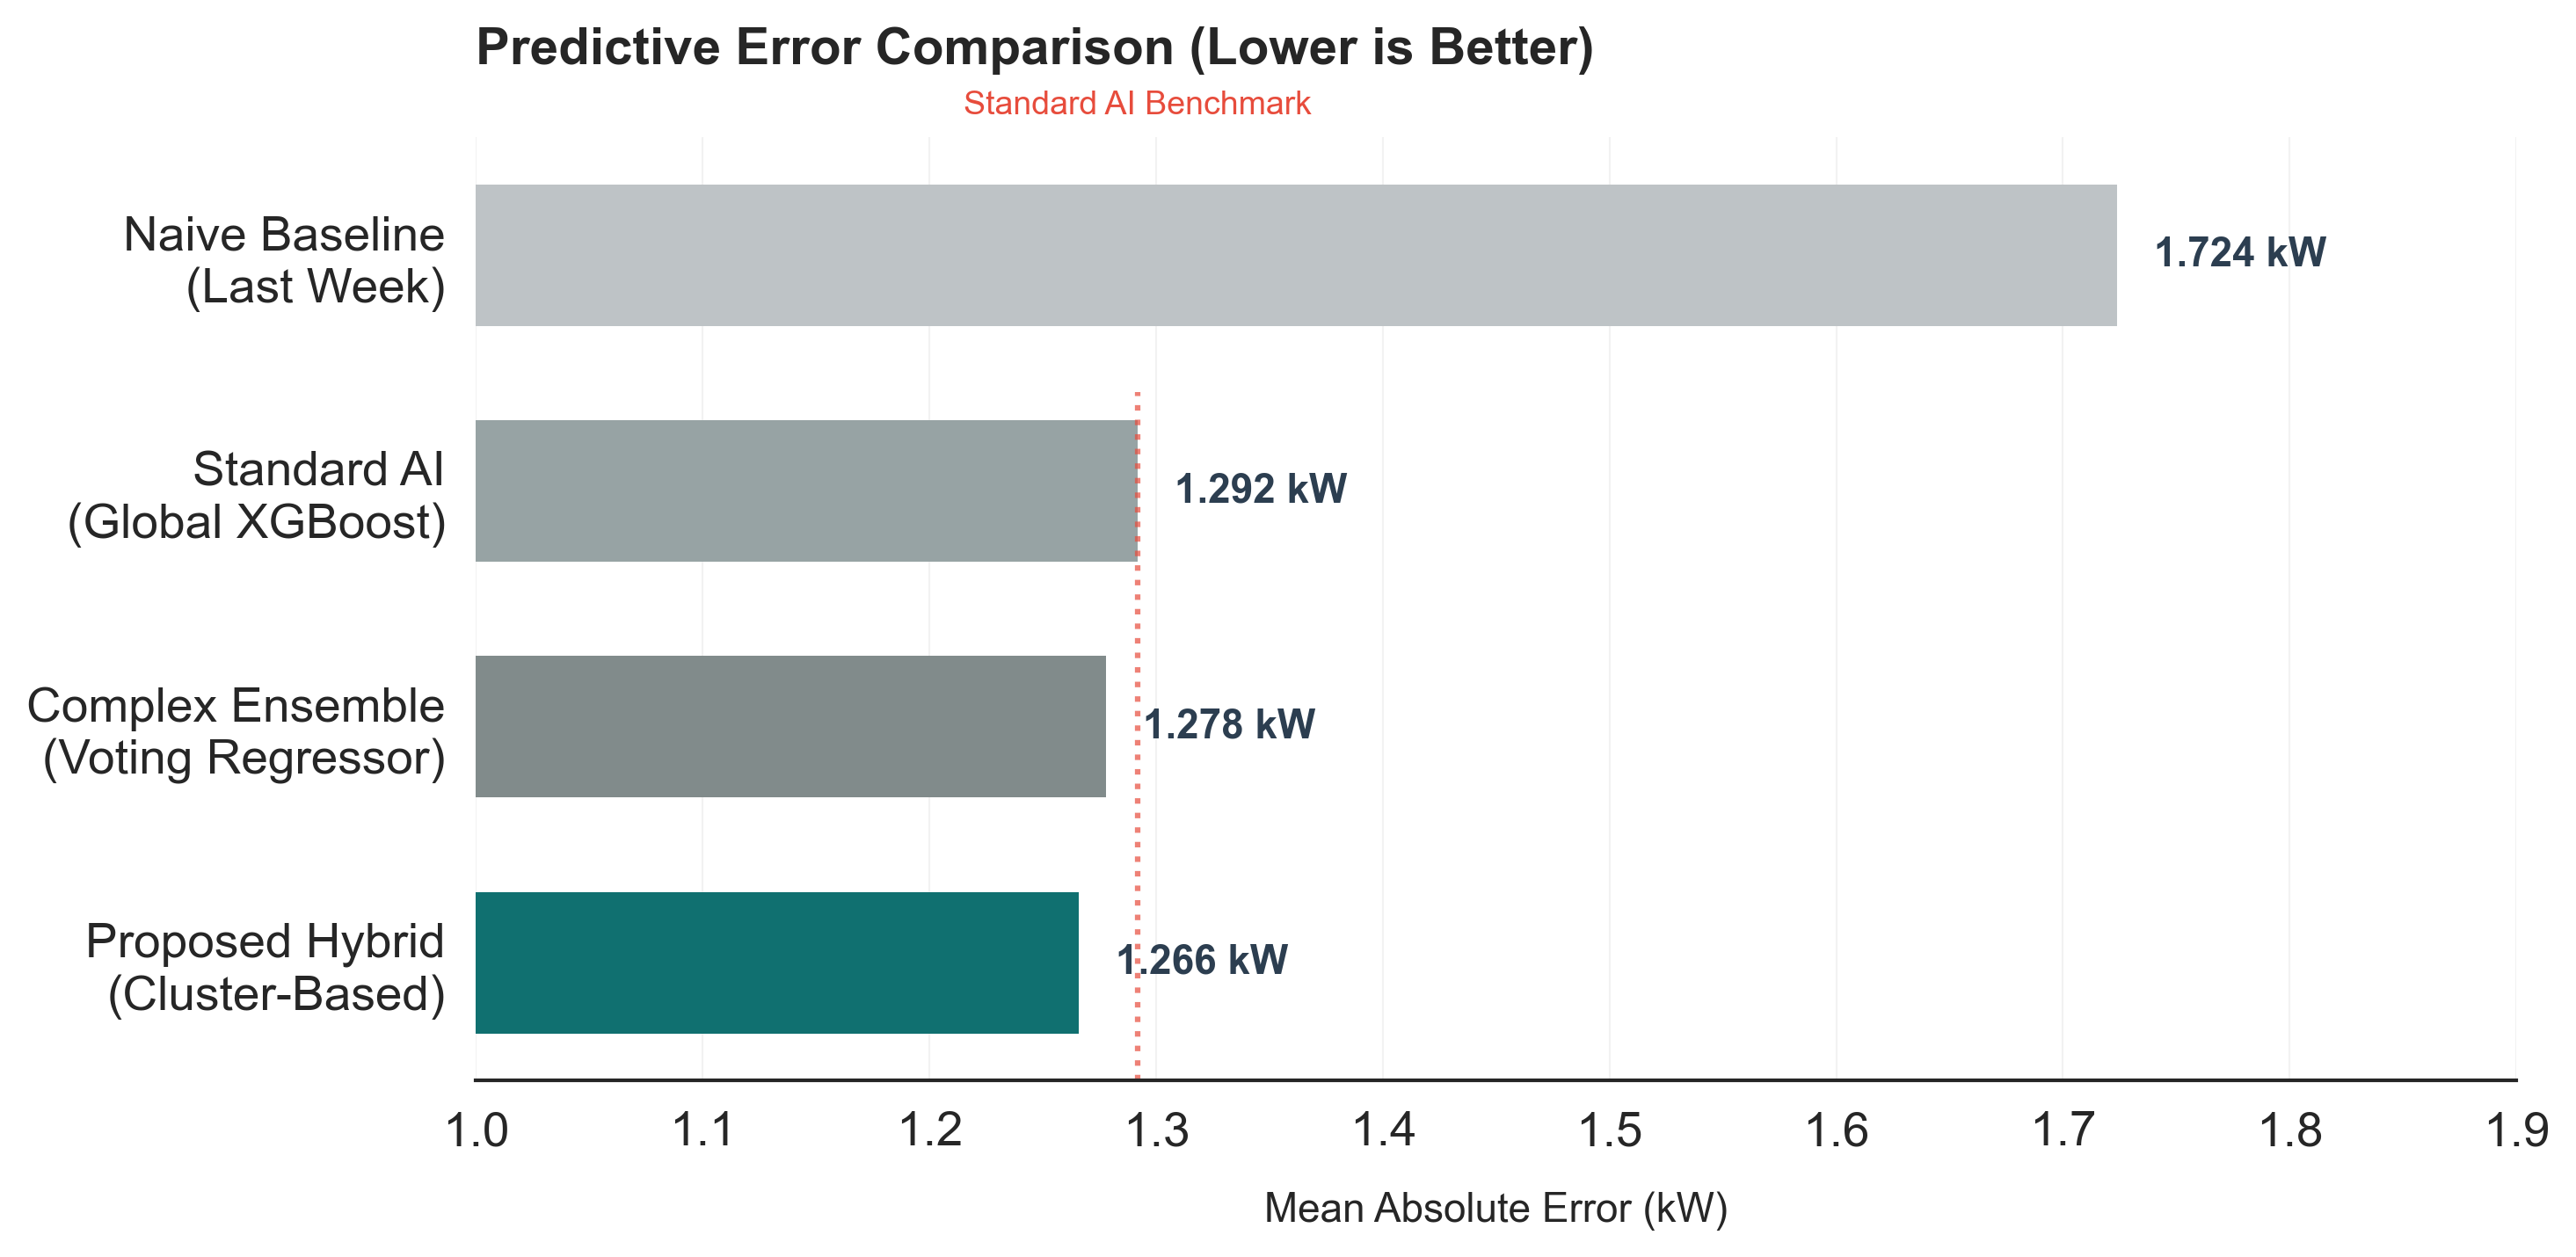

Graph saved as 'Figure_5_Model_Comparison.png'


In [17]:
def generate_paper_viz():
    # 1. DATA PREPARATION (Exact results from your experiments)
    data = {
        'Method': [
            'Naive Baseline\n(Last Week)',
            'Standard AI\n(Global XGBoost)',
            'Complex Ensemble\n(Voting Regressor)',
            'Proposed Hybrid\n(Cluster-Based)'
        ],
        'MAE': [1.724, 1.292, 1.278, 1.266],
        'Type': ['Baseline', 'Competitor', 'Competitor', 'Ours']
    }
    df_res = pd.DataFrame(data)

    # 2. STYLE CONFIGURATION (Modern Scientific)
    sns.set_style("white") # Clean background
    plt.rcParams['font.family'] = 'sans-serif'
    plt.figure(figsize=(10, 5), dpi=300) # High resolution for PDF/Print

    # Color Palette: Greys for competitors, Distinct Teal for your method
    # This guides the reviewer's eye immediately to your result.
    colors = ['#bdc3c7', '#95a5a6', '#7f8c8d', '#008080']

    ax = sns.barplot(
        data=df_res,
        y='Method',
        x='MAE',
        palette=colors,
        edgecolor='none',
        width=0.6
    )

    # 4. ANNOTATIONS & DETAILS
    # Add value labels inside or right next to bars
    for i, container in enumerate(ax.containers):
        ax.bar_label(
            container,
            fmt='%.3f kW',
            padding=10,
            fontsize=11,
            fontweight='bold',
            color='#2c3e50'
        )

    # Add a vertical line for the "Standard AI" to show the gap
    standard_score = 1.292
    plt.axvline(x=standard_score, color='#e74c3c', linestyle=':', linewidth=1.5, alpha=0.7, ymax=0.73)
    plt.text(standard_score, -0.6, 'Standard AI Benchmark', color='#e74c3c', ha='center', fontsize=9)

    # Title and Labels
    plt.title('Predictive Error Comparison (Lower is Better)', fontsize=14, pad=20, fontweight='bold', loc='left')
    plt.xlabel('Mean Absolute Error (kW)', fontsize=11, labelpad=10)
    plt.ylabel('')

    # Clean up the borders (Spines)
    sns.despine(left=True, bottom=False)

    # Zoom in to show the difference clearly
    plt.xlim(1.0, 1.9)
    plt.grid(axis='x', color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

    # 5. SAVE
    plt.tight_layout()
    plt.savefig('Figure_5_Model_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Graph saved as 'Figure_5_Model_Comparison.png'")

generate_paper_viz()